Pre-trained CNN model : MobileNet-v2

Computational complexity가 매우 낮아서 이용.



Detection Dataset : PASCAL VOC 2010

# Dataset preparing

For final results on the VOC 2010-12 datasets, we fine-tuned the CNN on VOC 2012 train and optimized our detection SVMs on VOC 2012 trainval.

In [ ]:
import torchvision

train_data_finetuning = torchvision.datasets.VOCDetection(root='data/finetuning',
                                                        year='2012',
                                                        image_set='train',
                                                        download=False)

train_data_SVM = torchvision.datasets.VOCDetection('data/SVM',
                                                  year='2012',
                                                  image_set='trainval',
                                                  download=False)

test_data = torchvision.datasets.VOCDetection('data/test',
                                              year='2007',
                                              image_set='trainval',
                                              download=False)

### asdf

In [2]:
import pandas as pd
import glob
import xml.etree.ElementTree as ET

def xml2csv(path):
    xml_list = []
    
    column_name = ['filename', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    
    for xml_file in sorted(glob.glob(path + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(float(bbx.find('xmin').text))
            ymin = int(float(bbx.find('ymin').text))
            xmax = int(float(bbx.find('xmax').text))
            ymax = int(float(bbx.find('ymax').text))
            label = member.find('name').text
            
            value = (root.find('filename').text,
                     int(root.find('size').find('width').text),
                     int(root.find('size').find('height').text),
                     label, xmin, ymin, xmax, ymax)
            
            xml_list.append(value)
    
    csv_file = pd.DataFrame(xml_list, columns=column_name)
    
    return csv_file

In [3]:
# finetuning_data_csv = xml2csv('./data/finetuning/VOCdevkit/VOC2012/Annotations')
# SVM_data_csv = xml2csv('./data/SVM/VOCdevkit/VOC2012/Annotations')
# test_data_csv = xml2csv('./data/test/VOCdevkit/VOC2007/Annotations')

### ㅁㄴㅇㄹ


In [33]:
import selectivesearch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


img_PIL = train_data_finetuning[9][0]
img = np.array(img_PIL)

_, regions = selectivesearch.selective_search(img, scale=300, min_size=2000)

In [45]:
rois = [box['rect'] for box in regions]

In [47]:
def convert_xyminmax(bboxes):
    out = []
    for bbox in bboxes:
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = xmin + bbox[2]
        ymax = ymin + bbox[3]
        out.append((xmin, ymin, xmax, ymax))
    
    return out

In [48]:
rois = convert_xyminmax(rois)

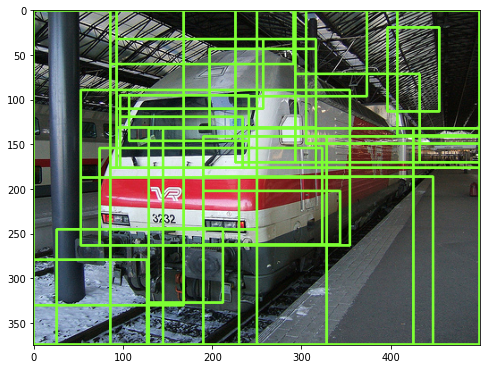

In [32]:
cand_rects = [box['rect'] for box in regions]

green_rgb = (125, 255, 51)
img_rgb_copy = img.copy()
for rect in cand_rects:

    left = rect[0]
    top = rect[1]
    # rect[2], rect[3]은 너비와 높이이므로 우하단 좌표를 구하기 위해 좌상단 좌표에 각각을 더함.
    right = left + rect[2]
    bottom = top + rect[3]

    img_rgb_copy = cv2.rectangle(img_rgb_copy, (left, top), (right, bottom), color=green_rgb, thickness=2)
    # 상자를 추가한 Image로 변수 변경

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb_copy)
plt.show()

In [ ]:
import torchvision.models as models
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
